## Searching for bouts for a day of alsa recording

In [1]:
%matplotlib inline

import os
import glob
import socket
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2021-07-09 12:23:52,616 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

### Get the file locations for a session (day) of recordings

In [3]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-29'}


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')

raw_folder = exp_struct['folders']['alsa']

In [4]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-29',
 'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-29/alsa',
 'kwik': '/scratch/earneodo/s_b1253_21/alsa/kwik/2021-06-29',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-29/alsa',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-29/alsa',
 'tmp': '/scratch/earneodo/tmp',
 'msort': '/scratch/earneodo/s_b1253_21/alsa/msort/2021-06-29',
 'ksort': '/scratch/earneodo/s_b1253_21/alsa/ksort/2021-06-29'}

#### search parameters
Spectrograms are computed using librosa

Additional parameters are for bout search criteria and functions to read the data

In [5]:
# function for getting one channel out of a wave file
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    return s_f, x[:, chan_id]

def sess_file_id(f_path):
    n = int(os.path.split(f_path)[1].split('-')[-1].split('.wav')[0])
    return n

hparams = {
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 2000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 5000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 120000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

#### Get one wave file

In [6]:
one_wav_path = os.path.join(exp_struct['folders']['alsa'], '09-00-01-02.wav')

s_f, x = read_wav_chan(one_wav_path)

hparams['sample_rate'] = s_f

In [7]:
x.shape

(81600000,)

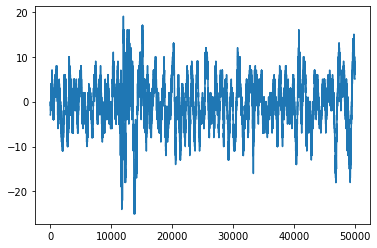

In [8]:
plt.plot(x[:50000])

### try the function to search for bouts in the file

In [9]:
from ceciestunepipe.util.sound import boutsearch as bs

In [10]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [11]:
#bpd, x, p = bs.get_bouts_in_file(one_wav_path, hparams)

bouts_file_path = '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-29/alsa/bouts_ceciestunepipe/bout_auto.pickle'

In [12]:
bpd = pd.read_pickle(bouts_file_path)

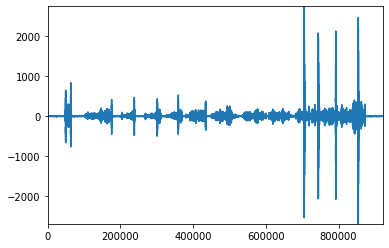

In [13]:
plt.plot(bpd['waveform'].values[0])

In [14]:
bpd

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,waveform,spectrogram
0,386220,403405,18538560,19363440,"[1.184938257587107, 2.4208140006067325, 0.7952...",2.355654,55.925494,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,17185,"[[386220, 386565], [387645, 387860], [387945, ...",74,"[6, 13, 24, 35, 45, 56, 64, 255, 287, 298, 305...",193,89.041451,"[-5, -5, -4, -5, -5, -5, -4, -3, -4, -4, -4, -...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1374510,1417635,65976480,68046480,"[1.162909673461553, 1.9454584380127675, 1.2650...",4.257527,173.941341,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,43125,"[[1374510, 1374720], [1374735, 1374810], [1376...",178,"[10, 23, 41, 49, 56, 340, 348, 355, 373, 380, ...",605,71.280992,"[7, 6, 6, 5, 5, 5, 5, 5, 3, 4, 5, 3, 4, 4, 4, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,119310,124500,5726880,5976000,"[24.402635779515865, 29.9121393129395, 25.7324...",3.657879,122.577027,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,5190,"[[119310, 119350], [120235, 120300], [120535, ...",10,"[1, 14, 34, 185, 247, 255, 398, 446, 531, 544,...",20,259.500000,"[-22, -20, -19, -17, -15, -14, -16, -15, -16, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,823780,862245,39541440,41387760,"[4.190658508647245, 6.408519407723347, 7.26849...",3.657879,175.715844,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,38465,"[[823780, 824115], [825590, 825945], [825955, ...",150,"[4, 16, 26, 35, 48, 55, 62, 356, 363, 370, 377...",531,72.438795,"[-2, -3, -2, -2, -1, -1, -1, -1, 0, 0, -1, -1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,244295,295845,11726160,14200560,"[3.927754416723628, 5.516490537116973, 5.05671...",8.273053,205.149649,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,51550,"[[244295, 244625], [246520, 246685], [246700, ...",153,"[6, 14, 28, 39, 52, 60, 449, 456, 464, 473, 48...",578,89.186851,"[-12, -12, -12, -11, -11, -10, -9, -10, -9, -9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1640535,1652395,78745680,79314960,"[82.13969134333, 62.61464610796436, 45.4542544...",2.703077,111.593736,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,11860,"[[1640535, 1640600], [1641115, 1641165], [1641...",20,"[4, 52, 61, 116, 190, 199, 324, 478, 549, 619,...",37,320.540541,"[-1, -1, 0, -1, -1, 0, 0, 0, -2, -1, 0, 0, -1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
101,1774740,1781460,85187520,85510080,"[70.67137314492564, 86.4128538871617, 60.78571...",2.703077,106.481450,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,6720,"[[1774740, 1774795], [1774985, 1775035], [1775...",12,"[1, 49, 72, 107, 150, 163, 412, 530, 553, 570,...",22,305.454545,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
102,1793840,1798865,86104320,86345520,"[13.498636366008258, 15.650307137330737, 18.98...",2.703077,113.578378,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,5025,"[[1793840, 1793870], [1794165, 1794205], [1794...",12,"[2, 67, 142, 149, 221, 505, 747, 757, 766, 778...",19,264.473684,"[3, 3, 4, 3, 3, 3, 4, 3, 2, 4, 4, 4, 4, 4, 3, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
103,5045,10840,242160,520320,"[50.71336751550965, 83.38786336067012, 72.7050...",3.247953,83.387863,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,5795,"[[5045, 5115], [5750, 5805], [7235, 7295], [75...",11,"[1, 10, 145, 226, 264, 442, 504, 516, 599, 661...",18,321.944444,"[3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### inspect the bouts and curate them

#### visualize one bout

In [15]:
bpd['spectrogram'] = bpd['waveform'].apply(lambda x: bs.gimmepower(x, hparams)[2])

In [16]:
bpd.iloc[0]

start_ms                                                   386220
end_ms                                                     403405
start_sample                                             18538560
end_sample                                               19363440
p_step          [1.184938257587107, 2.4208140006067325, 0.7952...
rms_p                                                    2.355654
peak_p                                                  55.925494
bout_check                                                   True
file            /mnt/sphere/speech_bci/raw_data/s_b1253_21/202...
len_ms                                                      17185
syl_in          [[386220, 386565], [387645, 387860], [387945, ...
n_syl                                                          74
peaks_p         [6, 13, 24, 35, 45, 56, 64, 255, 287, 298, 305...
n_peaks                                                       193
l_p_ratio                                               89.041451
waveform  

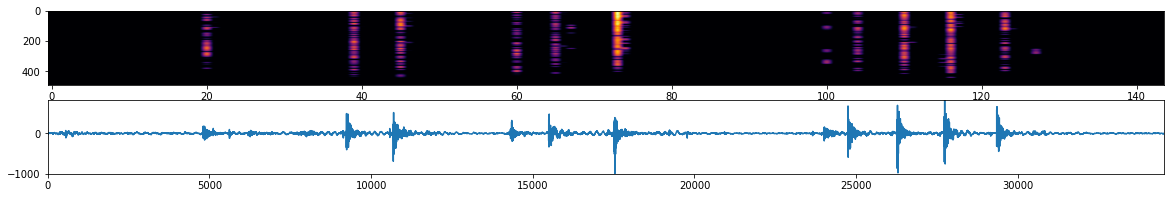

In [17]:
def viz_bout(df: pd.Series, ax_arr=None, sub_sample=10):
    # get the power and the spectrogram
    sxx = df['spectrogram'][:, ::sub_sample]
    x = df['waveform'][::sub_sample]
    
    if ax_arr is None:
        fig, ax_arr = plt.subplots(nrows=2, figsize=(20, 4))
    
    ax_arr[0].imshow(np.sqrt(sxx[::-1]), aspect='auto', cmap='inferno')
    ax_arr[1].plot(x)
    
fig, ax = plt.subplots(nrows=2, figsize=(20, 3))

viz_bout(bpd.iloc[2], ax)

#### use it in a widget


In [18]:
from IPython.display import display, clear_output

In [19]:
import ipywidgets as widgets

In [20]:
from traitlets import CInt, link

In [21]:
class Counter(widgets.DOMWidget):
    value = CInt(0)
    value.tag(sync=True)

In [37]:
class VizBout():
    def __init__(self, hparams, bouts_pd):
        self.bout = None
        self.bouts_pd = bouts_pd
        self.bout_series = None
        self.is_bout = None
        
        self.bout_counter = None
        self.bout_id = None
        
        self.buttons = {}
        self.m_pick = None
        
        self.fig = None
        self.fig_ax = {}
        self.fig_width = 2
        self.sub_sample = 10
        
        self.x = None
        self.sxx = None
        
        self.init_widget()
        self.init_fig()
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['waveform'] = self.fig.add_axes([0,0,self.fig_width,0.5])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,.5,self.fig_width,0.5])
        
        for ax in self.fig_ax.values():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        
        self.show()

    def init_widget(self):
        
        self.bout_counter = Counter()
        self.is_bout = widgets.Checkbox(description='is bout')
        
        self.buttons['Next'] = widgets.Button(description="Next", button_style='info',
                                              icon='plus')   
        self.buttons['Prev'] = widgets.Button(description="Prev", button_style='warning',
                                              icon='minus')
        self.buttons['Check'] = widgets.Button(description="Check", button_style='success', 
                                               icon='check')
        self.buttons['Uncheck'] = widgets.Button(description="Uncheck", button_style='danger',
                                                 icon='wrong')
        
        [b.on_click(self.button_click) for b in self.buttons.values()]
        
        left_box = widgets.VBox([self.buttons['Prev'], self.buttons['Uncheck']])
        right_box = widgets.VBox([self.buttons['Next'], self.buttons['Check']])
        button_box = widgets.HBox([left_box, right_box])

        self.m_pick = widgets.IntSlider(value=0, min=0, max=self.bouts_pd.index.size-1,step=1,
                                  description="MotCandidate")
        link((self.m_pick, 'value'), (self.bout_counter, 'value'))

        self.update_bout()
                
        display(button_box)
        display(self.m_pick)
        display(self.is_bout)
        
    def button_click(self, button):        
        self.bout_id = self.bout_counter.value
        curr_bout = self.bout_counter
        if button.description == 'Next':
            curr_bout.value += 1
        elif button.description == 'Prev':
            curr_bout.value -= 1
        elif button.description == 'Check':
            self.bouts_pd.set_value(self.bout_id, 'bout_check', True)
            curr_bout.value += 1
        elif button.description == 'Uncheck':
            self.bouts_pd.set_value(self.bout_id, 'bout_check', False)
            curr_bout.value += 1
    
    def slider_change(self, change):
        logger.info('slider changed')
        #self.bout_counter = change.new
        #clear_output(True)
        self.update_bout()
        self.show()
            
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.set_value(self.bout_id, 'bout_check', bc['new'])
    
    def update_bout(self):
        self.bout_id = self.bout_counter.value
        self.bout_series = self.bouts_pd.iloc[self.bout_id]
        self.x = self.bout_series['waveform'][::self.sub_sample]
        self.sxx = self.bout_series['spectrogram'][::self.sub_sample]
        
    def show(self):
        #self.fig.clf()
        #self.init_fig()
        # update
#         self.update_bout()
        #plot
        logger.info('showing')
        ax = self.fig_ax['spectrogram']
        ax.imshow(self.sxx[::-1], cmap='inferno', aspect='auto')
        ax.grid(False)

        ax = self.fig_ax['waveform']
        ax.plot(self.x)
        self.fig.canvas.draw()
        #display(self.fig)
        #ax.canvas.draw()
        self.is_bout.value = bool(self.bout_series['bout_check'])
        self.is_bout.observe(self.bout_checked, names='value')
        self.m_pick.observe(self.slider_change, names='value')
        #display(self.fig)
        plt.show()
    
ms = VizBout(hparams, bpd);

IntSlider(value=0, description='MotCandidate', max=104)

Checkbox(value=False, description='is bout')

2021-06-30 17:01:53,228 root         INFO     showing


<Figure size 432x288 with 0 Axes>

2021-06-30 17:01:55,851 root         INFO     slider changed
2021-06-30 17:01:55,852 root         INFO     showing
2021-06-30 17:01:56,659 root         INFO     slider changed
2021-06-30 17:01:56,661 root         INFO     showing
2021-06-30 17:01:57,139 root         INFO     slider changed
2021-06-30 17:01:57,141 root         INFO     showing
2021-06-30 17:01:57,350 root         INFO     slider changed
2021-06-30 17:01:57,352 root         INFO     showing


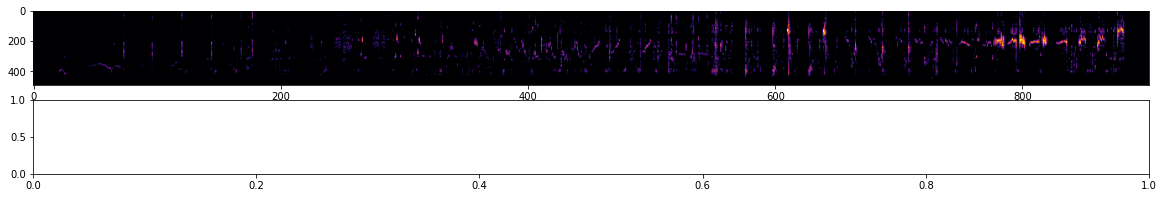

In [20]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(20, 3))

sxx = bpd.iloc[0]['spectrogram'][:, ::10]
ax_arr[0].imshow(sxx[::-1], aspect='auto', cmap='inferno')